In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### у меня не установлен
import shap

In [2]:
###
sns.set()

Выносим постоянные параметры в самый вверх ноутбука

In [3]:
TEST_SIZE = 0.2
RANDOM_STATE = 10
N_FOLDS = 3

**Главные моменты**:
- Писать код согласно стандарту PEP8, можете установать расширение в Jupyter - Nbextensions и править код при помощи Autopep8
- Если пишите методы и классы, то не забывать про Docstring + вынос методов, классов в отдельные модули или даже пакеты (если их много в notebook), чтобы они не занимали большую часть кода
- Подписывать графики, оси
- Делать заголовки для основных блоков кода, чтобы лучше ориентироваться в ноутбуке
- Давать пояснения в виде комменариев в коде
- Давать пояснения в виде текста при помощи разметки Markdown
- Писать type hints, чтобы понимать, какие типы данных вы подаете на вход методам, а какие возвращаете

# Загрузка данных

In [4]:
data = load_boston()

df = pd.DataFrame(columns=data.feature_names, data=data.data)
df['target'] = data.target

In [5]:
df[:5]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# EDA + Feature engineering

Изучаем информацию о пропусках и типах данных, а также изучаем сами даннные, выдвигаем гипотезы, строим графики, пример EDA https://youtu.be/kAwHoNqjrYU
https://github.com/miracl1e6/credit-scoring

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [7]:
df.shape

(506, 14)

Обязательно смотрим на статистики

In [8]:
df.describe(include='float')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


**Гипотезы**:

- 1) ...
- 2) ...
....

**1) Если есть пропуски, то как можно заполнить:**

- нулями для типа int, float
- -999 (наиболее невероятное значение) для типа int, float, в особенности, если хотим использовать модели на основе деревьев
- средними (среднее арифметическое, медиана, мода (в особенности для object))
- удаление пропусков (особенно, если их меньше 1%)
- 'None', либо смысловыми значениями наподобие 'Не определено' и т.д.
- сверяться с другими признаками, например, если есть дата рождения и возраст, то можно взять кол-во лет из самой даты

**2) Если есть выбросы, то что с ними делать:**

- Удаление строк с выбросами (особенно, если их меньше 1%)
- Предобработка выбросов (пример https://youtu.be/Vgm2ddpdnxA)
- Логарифмирование
- Статистические методы
- Использование кластеризации (методы на основе плотности)

Выбросы можно определить на этапе EDA, используя boxpolot, displot, статистики, методы кластеризации

**3) Перед тем, как выбрать модель нужно:**

- Обязательно исследовать момент с зависимостями признаков и целевой перменной, есть ли линейная зависимость, либо она более нетривиальная, от этого далее будет зависеть выбор модели
- Как распределена целевая переменная в задаче регрессии, если распределение target далеко от нормального (можно проверить при помощи критерия Шапиро-Уилка), то логарифмируем
- Если имеем задачу классификации, то смотрим, есть ли дисбаланс, если он есть, то можно использовать встроенные методы в самих моделях, обычно это параметр class_weight="balanced", либо SMOTE/oversampling/undersampling https://youtu.be/gZaj1aTfnZY
- Если есть признаки типа object, то для линейных моделей, деревьев решений необходимо преобразовать категориальные данных, например при помощи One-Hot-Encoding (pandas.get_dummies() + использовать drop_first=True, чтобы не попасть в ловушку фиктивной переменной), для многих других моделей поддерживаются встроенные обработчики категориальных признаков

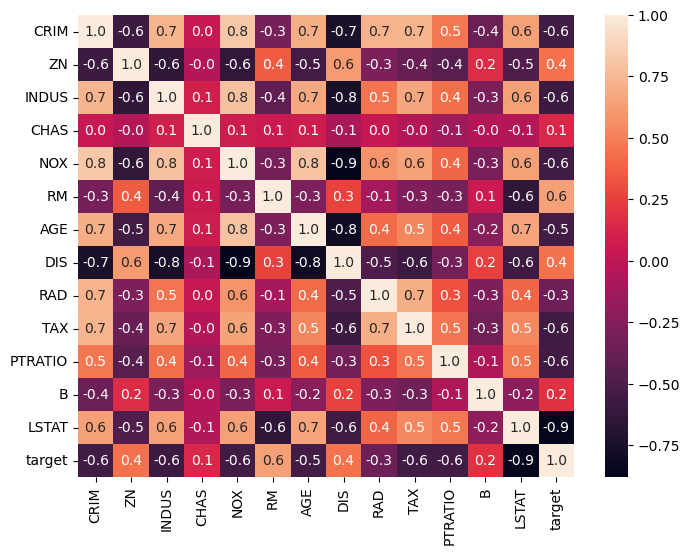

In [14]:
plt.figure(figsize=(8, 6))

sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".1f");

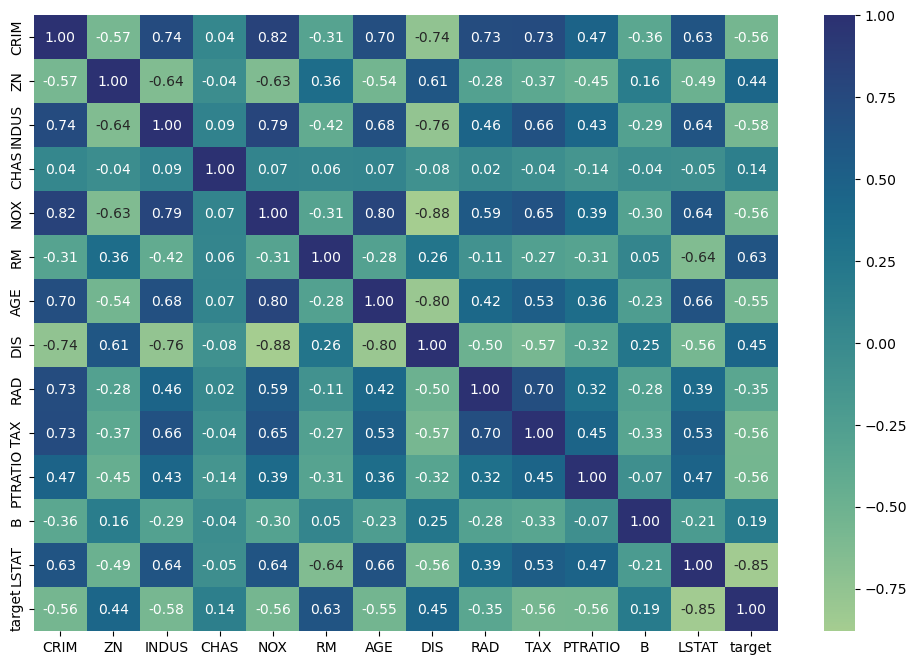

In [15]:
###
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".2f", cmap='crest');

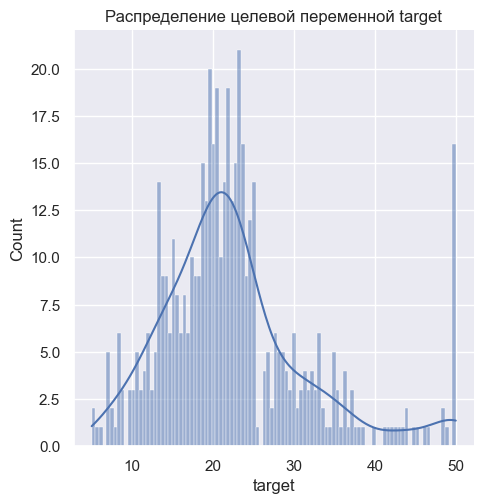

In [18]:
sns.displot(df.target, bins=100, kde=True)
plt.title('Распределение целевой переменной target');

In [19]:
print(stats.shapiro(df.target));

ShapiroResult(statistic=0.91717529296875, pvalue=4.940618243974614e-16)


In [21]:
### ненормальное распределение. Пролагорифмируем

In [5]:
df = df.assign(log_target=np.log(df.target + 1))

In [23]:
print(stats.shapiro(df.log_target));

ShapiroResult(statistic=0.9783119559288025, pvalue=7.71699149026972e-07)


In [ ]:
### все равно не нормальное

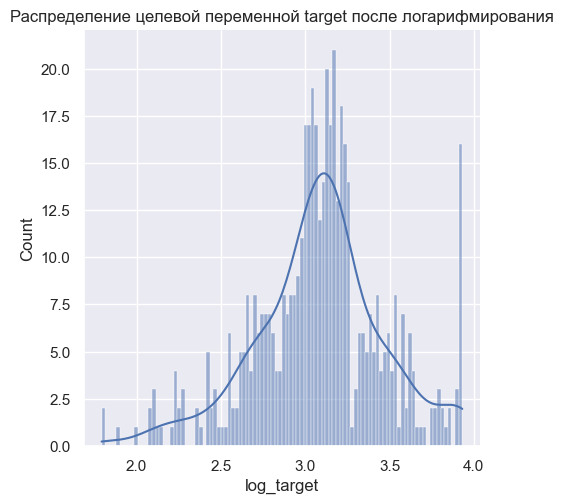

In [24]:
sns.displot(df.log_target, bins=100, kde=True)
plt.title('Распределение целевой переменной target после логарифмирования');

# Моделирование

**4) Нормализация:**
    
- При использовании линейных моделей
- При использовании метрических алгоритмов, например KNN
- При использовании нейронных сетей

Разбиение на тренировочные и тестовые данные.

In [7]:
### + нормализация данных

In [6]:
X = df.drop(columns=['log_target', 'target'], axis=1)
y = df['log_target'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

**5) Перед тем, как выбрать ту или иную модель, посмотреть:**

- Если признаков много (большой датасет), например больше 500-700 (примерно), то отбираем те признаки, которые могут повлиять на модель, так как иначе может возрастать вычислительная сложность
- Отбор признаков можно производить путем статист. подходов, с использованием моделей, либо перебором, подробнее о разных методах отбора признаков https://habr.com/ru/company/ods/blog/325422/
- Есть ли линейная зависимость между таргет меткой и признаками в данных, если она есть, то можем решить задачу при помощи линейных методов
- Если данных мало (примерно до 10000), то лучше использовать простые модели (не на основе бустинга над решаюшими деревьями)
- Если зависимость нетривиальная, то используем модели на основе деревьев, + если большой датасет и есть необходимые мощности, то бустинги, ансамбли, стеккинг 

**6) Выбор метрики:**

- Для регрессии выбираем метрики, которые можем использовать при оптимизации, например MSE, RLMSE и др., MAE уже будет нерелевантно использоваться, так как при использовании различных методов оптимизации в ML моделях возникает проблемы при дифференцировании
- Для классификации если нет дисбаланса, то можно даже смотреть на accuracy, при дисбалансе, f1, roc_auc, precision, recall, logloss (с ним аккуратнее, если есть значения вероятности равной 0/1) и др., здесь очень зависит от постановки самой задачи, подробнее часть метрик рассмотрена https://youtu.be/kAwHoNqjrYU

In [8]:
### метрика не используется во время самого обучения. Пусть недифференцируема. Нет?

In [15]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def exp(y: np.ndarray) -> np.ndarray:
    """
    Потенционирование (обратное логарифмирование) 
    """
    return np.exp(y) - 1

Всегда начинаем с Baseline (простых моделей без параметров), от которого будем дальше отталкиваться

In [16]:
models = [LinearRegression(), ElasticNet(), KNeighborsRegressor()]
scores = dict()

for m in models:
    m.fit(X_train_norm, y_train)
    y_pred = m.predict(X_test_norm)

    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(y_pred))), 3)}')
    print(f'MAE: {round(mean_absolute_error(exp(y_test), exp(y_pred)), 3)}')
    print(f'RMSLE: {round(rmsle(exp(y_test), exp(y_pred)), 3)}')
    print('-'*30, '\n')

model: LinearRegression()
RMSE: 5.327
MAE: 3.497
RMSLE: 0.198
------------------------------ 

model: ElasticNet()
RMSE: 11.378
MAE: 7.976
RMSLE: 0.412
------------------------------ 

model: KNeighborsRegressor()
RMSE: 6.111
MAE: 3.874
RMSLE: 0.197
------------------------------ 



**6) Подбор оптимальных параметров, моделирование + отбор важных признаков:**

- Для поиска оптимальных параметров модели. GridSearch: работает дольше, перебирает все варианты
- Optuna и др подобные методы. Быстрее работает, есть возможность выбирать направление процесса оптимизации, можно продолжать процесс поиска параметров даже после первого поиска, можно обнаруживать бесперспективные наборы гиперпараметров перед обучением, тем самым сокращая время поиска
- Используем также кросс-валидацию, чтобы избежать переобучения в том числе. Для дисбаланса обязательно брать методы со стратифицированной выборкой, например StratifiedKFold

In [17]:
parameters_grid = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "n_neighbors": range(1, 20),
    "metric": ['minkowski', 'euclidean']
}


model = KNeighborsRegressor()
cv = KFold(n_splits=3, shuffle=True)

grid_cv = GridSearchCV(model,
                       parameters_grid,
                       scoring='neg_mean_absolute_error',
                       cv=cv,
                       verbose=1)
grid_cv.fit(X_train_norm, y_train)

Fitting 3 folds for each of 304 candidates, totalling 912 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski', 'euclidean'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=1)

In [18]:
grid_cv.best_params_

{'algorithm': 'brute',
 'metric': 'minkowski',
 'n_neighbors': 7,
 'weights': 'distance'}

In [19]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

finish_test_preds = []

mae_predicts = np.empty(N_FOLDS)
rmsle_predicts = np.empty(N_FOLDS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train_norm, y_train)):
    X_train_, X_val = X_train_norm[train_idx], X_train_norm[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = KNeighborsRegressor(**grid_cv.best_params_)
    model.fit(X_train_, y_train_)

    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1

    mae_predicts[idx] = mean_absolute_error(y_val_exp, preds_exp)
    rmsle_predicts[idx] = rmsle(y_val_exp, preds_exp)

    preds_test = model.predict(X_test_norm)
    finish_test_preds.append(preds_test)

    print(
        f"id = {idx}, rmsle = {round(rmsle_predicts[idx], 3)}, mae = {round(mae_predicts[idx], 3)} \n")

print(np.mean(rmsle_predicts))

id = 0, rmsle = 0.15, mae = 2.136 

id = 1, rmsle = 0.151, mae = 2.615 

id = 2, rmsle = 0.219, mae = 3.029 

0.1732110219108347


In [20]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)

In [21]:
print(f'RMSE: {np.sqrt(mean_squared_error(exp(y_test), exp(test_pred)))}')
print(f'MAE: {mean_absolute_error(exp(y_test), exp(test_pred))}')
print(f'RMSLE: {rmsle(exp(y_test), exp(test_pred))}')

RMSE: 5.722327163759877
MAE: 3.7120477297572116
RMSLE: 0.18089338690910592


**7) Использование других моделей + итог:**
    
- Деревья решений, ансамбли, бустинги
- Если большой набор данных, то также рекомендуется попробовать применить стеккинг с несколькими уровнями моделей
- После чего сравнить результат и выбрать наиболее подходящую модель

# Feature importance

Важных этап включающий в себя не только анализ ТОП-фичей, но также разбор результатов для подтверждения тех или иных гипотез, которые стояли перед бизнесом, интерпретация результатов

**8) Подходы и этапы интерпретации:**
- permutation_importance дает более релевантную картину с важными признаками, в отличие от большинства встроенных методов feature_importance (кроме линейных моделей, catboost ...)
- SHAP, используется значения Шепли, есть возможность наглядно посмотреть, как значение каждого важного признака влияет на target
- Обязательно делать выводы по гипотезам из EDA, что удалось опровергнуть или наоборот 
- Рассмотреть важные признаки более деально, построить графики и сделать выводы на основании значений и статистик важных признаков, например, если задача классификации, то сравнить средние для каждого класса того или иного признака (это может помочь бизнесу в ряде задач и принятии решения)

In [22]:
perm = permutation_importance(model, X_test_norm, y_test, n_repeats=15)

In [23]:
perm_df = pd.DataFrame((perm['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

In [24]:
perm_df[:10]

,Score,Features
5,0.316573,RM
12,0.1369,LSTAT
10,0.041295,PTRATIO
3,0.033632,CHAS
6,0.032073,AGE
7,0.025451,DIS
0,0.021194,CRIM
4,0.019957,NOX
9,0.016643,TAX
11,0.013322,B


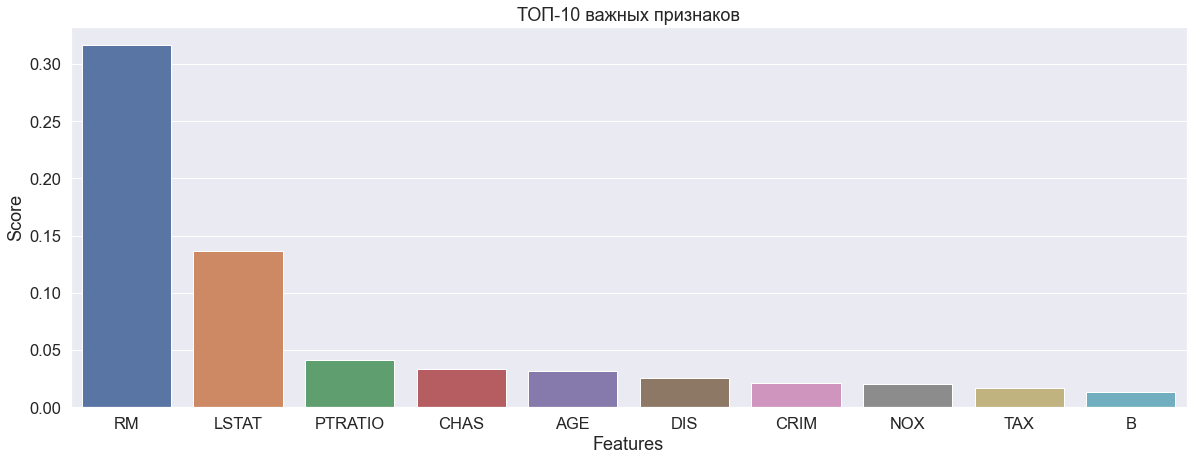

In [25]:
plt.figure(figsize=(20, 7))

sns.set(font_scale=1.5)
sns.barplot(x="Features", y="Score", data=perm_df[:10])
plt.title('ТОП-10 важных признаков')

plt.show()

In [ ]:
X_train_summary = shap.kmeans(X_train_norm, 2)

explainer = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = explainer.shap_values(X_test_norm)

  0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x='RM', y='target', data=df)
plt.title('Зависимость между RM и target')
plt.show()

# Результаты

- 1) ...
- 2) ...
...